In [1]:
import numpy as np
import cvxpy as cp
from scipy.io import loadmat
import pandas as pd
from simulate import sim
import matplotlib.pyplot as plt

First, read in problem parameters. These can come from any source, but they should be reshaped into `np.array` objects with dimensions specified in the docstring of `sim`.

In [2]:
# System base in MVA, taken from PowerWorld. Used to convert from MW to per-unit.
base = 100

# Key/value pairs are the names and contents of the sheets in the excel model data
model = pd.read_excel('Example11_9_Network_Model_Jul19.xlsx', sheet_name=None)

# The initial conditions of the demand curves
load = model['LoadProfiles'].set_index('Date')
load.index+=pd.TimedeltaIndex(load.HE-1, unit='h')
load = load.drop(columns='HE')
demand = np.array(load.loc[:,load.columns.str.contains('Load')]).T/base
price = np.array(load.loc[:,load.columns.str.contains('Price')]).T

# Generation profiles for intermittant sources
gen = pd.read_excel('Normalized generation profiles.xlsx', sheet_name='Normalized', index_col=0)
gen.index+=pd.TimedeltaIndex(gen.HE-1, unit='h')
gen = gen.drop(columns='HE')
gen = gen.loc[load.index, model['Gen']['Type']]
gen = np.array(gen*np.array(model['Gen']['Installed MW'])).T/base

# Process Ybus matrix
Y = model['YBus']
Y = Y.drop(columns=['Number', 'Name'])
Y = Y.apply(lambda row: row.str.replace('j', ''))
Y = Y.apply(lambda row: row.str.replace(' ', ''))
Y = Y + 'j'
Y = Y.fillna(0)
Y = Y.applymap(complex)
Y = np.array(Y)

# Number of buses
N = Y.shape[0]

# Susceptance matrix. Recall in DC power flow, G = 0 and shunt admittances are zero.
B = np.array(np.imag(Y))
B = B - np.diag(np.diag(B))
B = B - np.diag(np.sum(B, axis=0))

# Line constraints. The i, j element is the MVA limit of the line from bus i to bus j
P_line = np.zeros((N,N))
limits = model['Line']
P_line[limits['From Number']-1, limits['To Number']-1] = limits['Lim A MVA']
P_line = (P_line+P_line.T)/base

# The buses with generators and loads
L = np.array(model['Load']['Number of Bus']-1)
G = np.array(model['Gen']['Number of Bus']-1)

# Number of timesteps to fully charge/discharge storage
b_duration = 4

# Elasticity
epsilon = -0.5*np.ones((len(L), gen.shape[1]))

# Dispatchable generator costs
cost_lin = np.array([10,8,12])
cost_quad=np.array([.016,0.18,0.18])

# Value of lost load
voll = 25

To run a simulation, call `sim` as follows. Be careful with units!

In [3]:
opf = sim(
    L=L,
    G=G,
    B=B,
    p_g_int_max=gen,
    p_g_dis_min=np.array([0,0,0])/base, # To avoid nonconvex unit commitment problem
    p_g_dis_max=np.array(model['Gen']['Installed MW'])/base,
    epsilon = epsilon,
    price=price,
    demand=demand,
    b_total=2000/base,
    b_duration=4,
    p_line_max=P_line,
    cost_lin=cost_lin, # From PowerWorld
    cost_quad=np.array([.016,0.18,0.18]), # From PowerWorld
    generator_ratio=.5,
    voll=voll
)

Always retrieve the output as a dictionary, as the order of variables in `opf.variables()` may change from run to run.

In [4]:
output = {var.name(): var.value for var in opf.variables()}

A demonstration of how to visualize the results. Other variables can also be retrieved, such as transmission constraints and voltage angles.

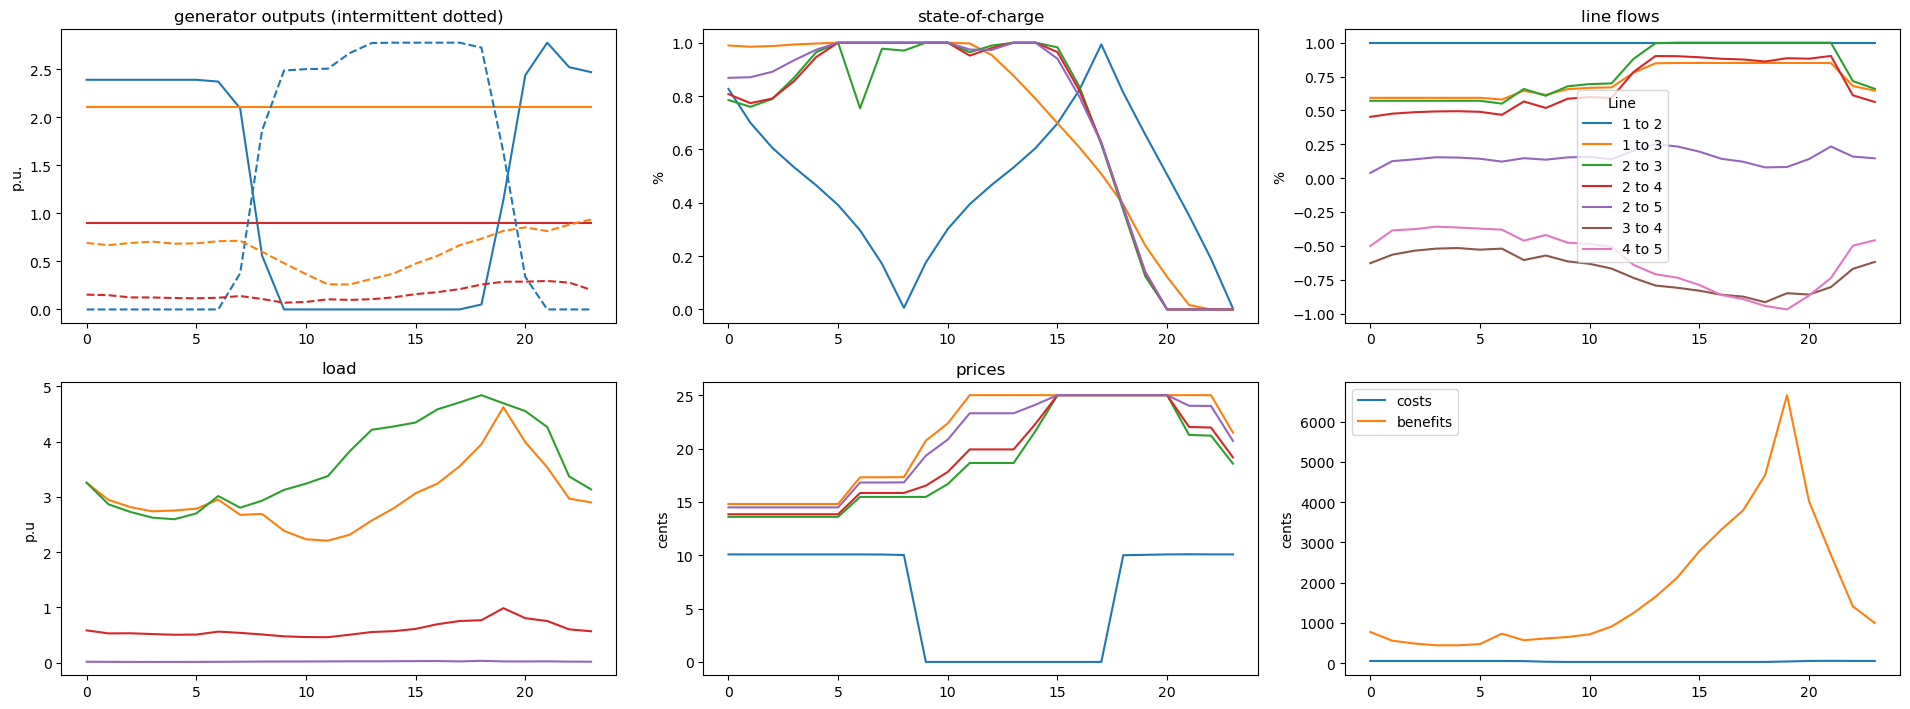

In [5]:
fig, ax = plt.subplots(2,3)

# The prices are the negative of the dual of the first constraint
ax[1,1].plot(-opf.constraints[0].dual_value.T)
ax[1,1].set_ylabel('cents')
ax[1,1].set_title('prices')
colors = np.array([line.get_color() for line in ax[1,1].lines])

# Generators
ax[0,0].plot(output['p_g_dis'].T)
ax[0,0].plot(output['p_g_int'].T,'--')
[line.set_color(colors[G][i%len(G)]) for i, line in enumerate(ax[0,0].lines)]
ax[0,0].set_ylabel('p.u.')
ax[0,0].set_title('generator outputs (intermittent dotted)')

# Storage
ax[0,1].plot((output['b_0']+np.cumsum(output['p_b'],axis=1).T)/output['b'])
ax[0,1].set_ylabel('%')
ax[0,1].set_title('state-of-charge')

congestion = [
    B*(delta_t[:,np.newaxis]-delta_t[np.newaxis,:])
    for delta_t in output['delta'].T
]
idx = np.array(np.where(P_line != 0))
[
    ax[0,2].plot(
        [
            M[i,j]/P_line[i,j]
            for M in congestion  
        ],
        label=f'{i+1} to {j+1}'
    ) for i, j in idx[:,idx[0] < idx[1]].T
]
ax[0,2].set_title('line flows ')
ax[0,2].set_ylabel('%')
ax[0,2].legend(title='Line')

# Loads
ax[1,0].plot((output['p_d_low']+output['p_d_high']).T)
[line.set_color(colors[L][i%len(L)]) for i, line in enumerate(ax[1,0].lines)]
ax[1,0].set_ylabel('p.u')
ax[1,0].set_title('load')


# Utility
p_voll = (voll/price)**epsilon*demand
ax[1,2].plot(cost_lin@output['p_g_dis']+cost_quad@output['p_g_dis']**2, label='costs')
ax[1,2].plot(
    (voll*output['p_d_low'] + price/demand**(1/epsilon)*epsilon/(1+epsilon)*((p_voll+output['p_d_high'])**(1/epsilon+1) - p_voll)).sum(axis=0), 
    label='benefits'
)
ax[1,2].set_ylabel('cents')
ax[1,2].legend()

fig.set_size_inches(fig.get_size_inches()*[3,1.5])
fig.tight_layout()
fig.show()